<a href="https://colab.research.google.com/github/starstar007/Thesis-Haotong-Bi/blob/main/Thesis_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langdetect
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
from langdetect import detect, LangDetectException
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer


file_path = '/content/drive/My Drive/SPOTIFY_REVIEWS 2.csv'

data = pd.read_csv(file_path)

# transform review_timestamp to datetime
data['review_date'] = pd.to_datetime(data['review_timestamp'])

filtered_data = data[(data['review_date'] >= '2022-01-01') & (data['review_date'] <= '2023-12-31')]

filtered_data = filtered_data.drop(columns=['review_date'])


def validate_rating(rating):
    try:
        rating = int(rating)
        if rating in [1, 5]:  # 只保留 1 和 5
            return rating
    except ValueError:
        return np.nan
    return np.nan

filtered_data['review_rating'] = filtered_data['review_rating'].apply(validate_rating)
filtered_data = filtered_data.dropna(subset=['review_rating'])


def categorize_rating(rating):
    if rating == 5:
        return 'positive'
    elif rating == 1:
        return 'negative'
    else:
        return np.nan

filtered_data['sentiment_category'] = filtered_data['review_rating'].apply(categorize_rating)
filtered_data = filtered_data.dropna(subset=['sentiment_category'])


filtered_data = filtered_data[filtered_data['review_text'].str.strip().astype(bool)]

#detect english
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False

filtered_data['review_text'] = filtered_data['review_text'].astype(str)
filtered_data = filtered_data[filtered_data['review_text'].apply(is_english)]

# remove emoij
def is_meaningful(text):
    return bool(re.sub(r'[^\w\s,]', '', text).strip())

filtered_data = filtered_data[filtered_data['review_text'].apply(is_meaningful)]

# lower
filtered_data['review_text'] = filtered_data['review_text'].str.lower()

# remove num
filtered_data['review_text'] = filtered_data['review_text'].apply(lambda x: re.sub(r'[\d+]', '', x))
filtered_data['review_text'] = filtered_data['review_text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# lemmatization
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
filtered_data['review_text'] = filtered_data['review_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# remove stopword
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
filtered_data['review_text'] = filtered_data['review_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# sentiment intensity
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
filtered_data['sentiment_scores'] = filtered_data['review_text'].apply(lambda x: sia.polarity_scores(x))
filtered_data['compound'] = filtered_data['sentiment_scores'].apply(lambda x: x['compound'])


filtered_data.to_csv('/content/drive/My Drive/processed_spotify_reviews_filtered_1_5.csv', index=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd


file_path = '/content/drive/My Drive/processed_spotify_reviews_filtered_1_5.csv'
filtered_data = pd.read_csv(file_path)


from sklearn.model_selection import train_test_split



X_train, X_temp, y_train, y_temp = train_test_split(filtered_data['review_text'], filtered_data['sentiment_category'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Mounted at /content/drive
Training set size: 380324
Validation set size: 47541
Test set size: 47541


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import make_pipeline
# remove NaN 值
X_train = X_train[X_train.notna()]
y_train = y_train[X_train.index]
X_val = X_val[X_val.notna()]
y_val = y_val[X_val.index]
X_test = X_test[X_test.notna()]
y_test = y_test[X_test.index]


nb_pipeline = make_pipeline(TfidfVectorizer(max_features=1000), MultinomialNB())
nb_pipeline.fit(X_train, y_train)


nb_val_accuracy = nb_pipeline.score(X_val, y_val)
print("Naive Bayes Validation Accuracy:", nb_val_accuracy)


nb_test_accuracy = nb_pipeline.score(X_test, y_test)
print("Naive Bayes Test Accuracy:", nb_test_accuracy)


Naive Bayes Validation Accuracy: 0.9080021889206937
Naive Bayes Test Accuracy: 0.9072214855507146


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Evaluate on validation set
nb_val_pred = nb_pipeline.predict(X_val)
nb_val_accuracy = accuracy_score(y_val, nb_val_pred)
nb_val_precision = precision_score(y_val, nb_val_pred, pos_label='positive')
nb_val_recall = recall_score(y_val, nb_val_pred, pos_label='positive')
nb_val_f1 = f1_score(y_val, nb_val_pred, pos_label='positive')

print("Naive Bayes Validation Accuracy:", nb_val_accuracy)
print("Naive Bayes Validation Precision:", nb_val_precision)
print("Naive Bayes Validation Recall:", nb_val_recall)
print("Naive Bayes Validation F1 Score:", nb_val_f1)

# Evaluate on test set
nb_test_pred = nb_pipeline.predict(X_test)
nb_test_accuracy = accuracy_score(y_test, nb_test_pred)
nb_test_precision = precision_score(y_test, nb_test_pred, pos_label='positive')
nb_test_recall = recall_score(y_test, nb_test_pred, pos_label='positive')
nb_test_f1 = f1_score(y_test, nb_test_pred, pos_label='positive')

print("Naive Bayes Test Accuracy:", nb_test_accuracy)
print("Naive Bayes Test Precision:", nb_test_precision)
print("Naive Bayes Test Recall:", nb_test_recall)
print("Naive Bayes Test F1 Score:", nb_test_f1)



Naive Bayes Validation Accuracy: 0.9080021889206937
Naive Bayes Validation Precision: 0.9253161438659878
Naive Bayes Validation Recall: 0.8982821156682211
Naive Bayes Validation F1 Score: 0.9115987460815048
Naive Bayes Test Accuracy: 0.9072214855507146
Naive Bayes Test Precision: 0.9223731059037841
Naive Bayes Test Recall: 0.8979123004997582
Naive Bayes Test F1 Score: 0.9099783523261038


In [ ]:
nb_val_precision_neg = precision_score(y_val, nb_val_pred, pos_label='negative')
nb_val_recall_neg = recall_score(y_val, nb_val_pred, pos_label='negative')
nb_val_f1_neg = f1_score(y_val, nb_val_pred, pos_label='negative')
print("Naive Bayes Validation Precision (Negative):", nb_val_precision_neg)
print("Naive Bayes Validation Recall (Negative):", nb_val_recall_neg)
print("Naive Bayes Validation F1 Score (Negative):", nb_val_f1_neg)

nb_test_precision_neg = precision_score(y_test, nb_test_pred, pos_label='negative')
nb_test_recall_neg = recall_score(y_test, nb_test_pred, pos_label='negative')
nb_test_f1_neg = f1_score(y_test, nb_test_pred, pos_label='negative')
print("Naive Bayes Test Precision (Negative):", nb_test_precision_neg)
print("Naive Bayes Test Recall (Negative):", nb_test_recall_neg)
print("Naive Bayes Test F1 Score (Negative):", nb_test_f1_neg)


Naive Bayes Validation Precision (Negative): 0.8897909828986008
Naive Bayes Validation Recall (Negative): 0.9188779378316907
Naive Bayes Validation F1 Score (Negative): 0.9041005726321333
Naive Bayes Test Precision (Negative): 0.8915528535342724
Naive Bayes Test Recall (Negative): 0.9173972421692586
Naive Bayes Test F1 Score (Negative): 0.9042904290429042


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# remove Nan non string
filtered_data = filtered_data[filtered_data['review_text'].apply(lambda x: isinstance(x, str))]
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# encode the label
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)


max_words = 1000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(filtered_data['review_text'])
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_pad, y_train_encoded, batch_size=32, epochs=5, validation_data=(X_val_pad, y_val_encoded))
bilstm_test_accuracy = model.evaluate(X_test_pad, y_test_encoded, verbose=0)[1]
print("BiLSTM Test Accuracy:", bilstm_test_accuracy)


Epoch 1/5
11877/11877 [==============================] - 129s 11ms/step - loss: 0.2106 - accuracy: 0.9183 - val_loss: 0.1919 - val_accuracy: 0.9277
Epoch 2/5
11877/11877 [==============================] - 113s 10ms/step - loss: 0.1898 - accuracy: 0.9275 - val_loss: 0.1837 - val_accuracy: 0.9312
Epoch 3/5
11877/11877 [==============================] - 111s 9ms/step - loss: 0.1813 - accuracy: 0.9312 - val_loss: 0.1812 - val_accuracy: 0.9325
Epoch 4/5
11877/11877 [==============================] - 111s 9ms/step - loss: 0.1748 - accuracy: 0.9345 - val_loss: 0.1805 - val_accuracy: 0.9333
Epoch 5/5
11877/11877 [==============================] - 109s 9ms/step - loss: 0.1685 - accuracy: 0.9366 - val_loss: 0.1832 - val_accuracy: 0.9327
BiLSTM Test Accuracy: 0.9310896396636963


In [ ]:
y_val_pred = (model.predict(X_val_pad) > 0.5).astype("int32")
y_test_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


val_accuracy = accuracy_score(y_val_encoded, y_val_pred)
val_precision = precision_score(y_val_encoded, y_val_pred)
val_recall = recall_score(y_val_encoded, y_val_pred)
val_f1 = f1_score(y_val_encoded, y_val_pred)

print("BiLSTM Validation Accuracy:", val_accuracy)
print("BiLSTM Validation Precision:", val_precision)
print("BiLSTM Validation Recall:", val_recall)
print("BiLSTM Validation F1 Score:", val_f1)


test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
test_precision = precision_score(y_test_encoded, y_test_pred)
test_recall = recall_score(y_test_encoded, y_test_pred)
test_f1 = f1_score(y_test_encoded, y_test_pred)

print("BiLSTM Test Accuracy:", test_accuracy)
print("BiLSTM Test Precision:", test_precision)
print("BiLSTM Test Recall:", test_recall)
print("BiLSTM Test F1 Score:", test_f1)

1485/1485 [==============================] - 5s 4ms/step
BiLSTM Validation Accuracy: 0.932690688668126
BiLSTM Validation Precision: 0.9398079318519709
BiLSTM Validation Recall: 0.9322412212523417
BiLSTM Validation F1 Score: 0.9360092844565392
BiLSTM Test Accuracy: 0.9310896423986025
BiLSTM Test Precision: 0.9374441465594281
BiLSTM Test Recall: 0.9301144607448009
BiLSTM Test F1 Score: 0.9337649200890148


In [ ]:

!pip install tensorflow==2.15.0 transformers==4.32.0
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from transformers import XLNetTokenizer, TFXLNetForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.6 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.2
    Uninstalling transformers-4.40.2:
      Successfully uninstalled transformers-4.40.2


/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Load the tokenizer and model
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model = TFXLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=len(label_encoder.classes_))

# Tokenize the data
def tokenize_data(texts):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=128, return_tensors="tf")

train_encodings = tokenize_data(X_train.tolist())
val_encodings = tokenize_data(X_val.tolist())
test_encodings = tokenize_data(X_test.tolist())

# Convert encoded data into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']}, y_train_encoded)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']}, y_val_encoded)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask']}, y_test_encoded)).batch(32)

# Compile the model using the correct reference to the Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Training the model
model.fit(train_dataset, epochs=2, validation_data=val_dataset)
results = model.evaluate(test_dataset)
print(f"Test loss: {results[0]}, Test accuracy: {results[1]}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/565M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertF

Epoch 1/2


11877/11877 [==============================] - 12173s 1s/step - loss: 0.2005 - accuracy: 0.9252 - val_loss: 0.1608 - val_accuracy: 0.9455
Epoch 2/2
1485/1485 [==============================] - 500s 337ms/step - loss: 0.1537 - accuracy: 0.9484
Test loss: 0.1537051498889923, Test accuracy: 0.9483698606491089


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Tokenize the data
def tokenize_data(texts):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=128, return_tensors="tf")

train_encodings = tokenize_data(X_train.tolist())
val_encodings = tokenize_data(X_val.tolist())
test_encodings = tokenize_data(X_test.tolist())

# Convert encoded data into NumPy arrays
X_val_input_ids = val_encodings['input_ids'].numpy()
X_val_attention_mask = val_encodings['attention_mask'].numpy()
X_test_input_ids = test_encodings['input_ids'].numpy()
X_test_attention_mask = test_encodings['attention_mask'].numpy()

# Function to make predictions in batches
def predict_in_batches(model, input_ids, attention_mask, batch_size=16):
    num_samples = input_ids.shape[0]
    predictions = []
    for i in range(0, num_samples, batch_size):
        batch_input_ids = input_ids[i:i+batch_size]
        batch_attention_mask = attention_mask[i:i+batch_size]
        batch_logits = model.predict({'input_ids': batch_input_ids, 'attention_mask': batch_attention_mask}).logits
        batch_predictions = np.argmax(batch_logits, axis=-1)
        predictions.extend(batch_predictions)
    return np.array(predictions)

# Predict on validation and test sets in batches
y_val_pred = predict_in_batches(model, X_val_input_ids, X_val_attention_mask, batch_size=16)
y_test_pred = predict_in_batches(model, X_test_input_ids, X_test_attention_mask, batch_size=16)

# Calculate metrics for validation set
val_accuracy = accuracy_score(y_val_encoded, y_val_pred)
val_precision = precision_score(y_val_encoded, y_val_pred, average='weighted')
val_recall = recall_score(y_val_encoded, y_val_pred, average='weighted')
val_f1 = f1_score(y_val_encoded, y_val_pred, average='weighted')

print("XLNet Validation Accuracy:", val_accuracy)
print("XLNet Validation Precision:", val_precision)
print("XLNet Validation Recall:", val_recall)
print("XLNet Validation F1 Score:", val_f1)

# Calculate metrics for test set
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
test_precision = precision_score(y_test_encoded, y_test_pred, average='weighted')
test_recall = recall_score(y_test_encoded, y_test_pred, average='weighted')
test_f1 = f1_score(y_test_encoded, y_test_pred, average='weighted')

print("XLNet Test Accuracy:", test_accuracy)
print("XLNet Test Precision:", test_precision)
print("XLNet Test Recall:", test_recall)
print("XLNet Test F1 Score:", test_f1)



流式输出内容被截断，只能显示最后 5000 行内容。
1/1 [==============================] - 0s 89ms/step
XLNet Validation Accuracy: 0.9483498905539653
XLNet Validation Precision: 0.9483713936099328
XLNet Validation Recall: 0.9483498905539653
XLNet Validation F1 Score: 0.9483325640998873
XLNet Test Accuracy: 0.9483698511923555
XLNet Test Precision: 0.9484021079751549
XLNet Test Recall: 0.9483698511923555
XLNet Test F1 Score: 0.9483550367458956


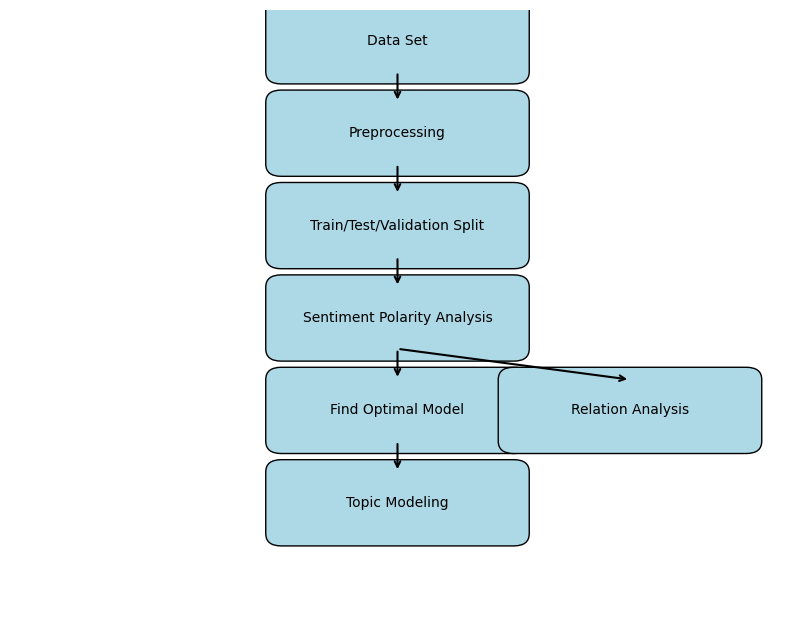

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# Function to create a rounded box
def create_rounded_box(ax, x, y, text):
    box = FancyBboxPatch((x, y), width=0.3, height=0.1, boxstyle="round,pad=0.02", edgecolor='black', facecolor='lightblue')
    ax.add_patch(box)
    ax.text(x + 0.15, y + 0.05, text, ha='center', va='center', fontsize=10)

fig, ax = plt.subplots(figsize=(10, 8))

# Remove axes
ax.axis('off')

# Define positions for the boxes
positions = {
    "Data Set": (0.35, 0.9),
    "Preprocessing": (0.35, 0.75),
    "Train/Test/Validation Split": (0.35, 0.6),
    "Sentiment Polarity Analysis": (0.35, 0.45),
    "Find Optimal Model": (0.35, 0.3),
    "Topic Modeling": (0.35, 0.15),
    "Relation Analysis": (0.65, 0.3)
}

# Create boxes
for text, (x, y) in positions.items():
    create_rounded_box(ax, x, y, text)

# Draw arrows
arrow_params = dict(arrowstyle='->', color='black', lw=1.5)
arrows = [
    ("Data Set", "Preprocessing"),
    ("Preprocessing", "Train/Test/Validation Split"),
    ("Train/Test/Validation Split", "Sentiment Polarity Analysis"),
    ("Sentiment Polarity Analysis", "Relation Analysis"),
    ("Sentiment Polarity Analysis", "Find Optimal Model"),
    ("Find Optimal Model", "Topic Modeling")
]

for start, end in arrows:
    start_pos = positions[start]
    end_pos = positions[end]
    ax.annotate('', xy=(end_pos[0] + 0.15, end_pos[1] + 0.1), xytext=(start_pos[0] + 0.15, start_pos[1]), arrowprops=arrow_params)


plt.show()



In [ ]:
!pip install graphviz

from graphviz import Digraph

def draw_flowchart(title, steps):
    dot = Digraph(comment=title)

    for i, step in enumerate(steps):
        dot.node(str(i), step)
        if i > 0:
            dot.edge(str(i-1), str(i))

    return dot

# Preprocessing Steps
preprocessing_steps = [
    "Convert review_timestamp to datetime format",
    "Filter comments from 2022 to 2023",
    "Clean invalid ratings (retain only 1 and 5)",
    "Convert review texts to lowercase",
    "Remove numerical and special characters",
    "Lemmatize review texts",
    "Remove stop words"
]

# Data Cleaning Steps
data_cleaning_steps = [
    "Remove empty or whitespace-only reviews",
    "Filter non-English comments",
    "Exclude reviews with only emojis or symbols",
    "Categorize sentiments (1 as negative, 5 as positive)",
    "Analyze sentiment intensity using VADER",
    "Add compound sentiment score"
]

# Draw and save flowcharts
preprocessing_chart = draw_flowchart("Preprocessing Steps", preprocessing_steps)
data_cleaning_chart = draw_flowchart("Data Cleaning Steps", data_cleaning_steps)

# Save the charts as PDF files
preprocessing_chart.render('preprocessing_steps', format='png', cleanup=True)
data_cleaning_chart.render('data_cleaning_steps', format='png', cleanup=True)

# Display the charts
preprocessing_chart.view()
data_cleaning_chart.view()


'data_cleaning_steps.pdf'

In [ ]:
!pip install tensorflow==2.15.0 transformers==4.32.0
!pip install langdetect
!pip install scikit-learn

import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import XLNetTokenizer, TFXLNetForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from langdetect import detect, LangDetectException
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer



# 删除 NaN 值
filtered_data = filtered_data.dropna(subset=['review_text', 'sentiment_category'])

# 分割数据集
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(filtered_data['review_text'], filtered_data['sentiment_category'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 过滤非字符串数据
X_train = X_train[X_train.notna()]
y_train = y_train[X_train.index]
X_val = X_val[X_val.notna()]
y_val = y_val[X_val.index]
X_test = X_test[X_test.notna()]
y_test = y_test[X_test.index]

# 对标签进行编码
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# 加载XLNet模型和tokenizer
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model = TFXLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=len(label_encoder.classes_))

# 令牌化数据
def tokenize_data(texts):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=128, return_tensors="tf")

train_encodings = tokenize_data(X_train.tolist())
val_encodings = tokenize_data(X_val.tolist())
test_encodings = tokenize_data(X_test.tolist())

# 转换为TensorFlow数据集
train_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']}, y_train_encoded)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']}, y_val_encoded)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask']}, y_test_encoded)).batch(32)

# 编译和训练模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_dataset, epochs=2, validation_data=val_dataset)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.2
    Uninstalling transformers-4.40.2:
      Successfully uninstalled transformers-4.40.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=62d25ab7ae6c135cfbaed4981db5d0e4c9fc25948a2b656e85ecf7f3e5a839be
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/565M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertF

Epoch 1/2


11877/11877 [==============================] - 12520s 1s/step - loss: 0.1976 - accuracy: 0.9270 - val_loss: 0.1638 - val_accuracy: 0.9436
Epoch 2/2
11877/11877 [==============================] - 12441s 1s/step - loss: 0.1587 - accuracy: 0.9454 - val_loss: 0.1584 - val_accuracy: 0.9475


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(filtered_data['review_text'], filtered_data['sentiment_category'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 过滤非字符串数据
X_train = X_train[X_train.notna()]
y_train = y_train[X_train.index]
X_val = X_val[X_val.notna()]
y_val = y_val[X_val.index]
X_test = X_test[X_test.notna()]
y_test = y_test[X_test.index]
# 减少预测时的内存消耗
def predict_in_batches(model, dataset, batch_size=16):
    logits = []
    for batch in dataset:
        inputs, _ = batch
        batch_logits = model.predict(inputs, batch_size=batch_size, use_multiprocessing=True).logits
        logits.append(batch_logits)
    return np.concatenate(logits, axis=0)

# 预测负面评论
test_logits = predict_in_batches(model, test_dataset, batch_size=16)
test_preds = np.argmax(test_logits, axis=-1)
negative_indices = np.where(test_preds == label_encoder.transform(['negative'])[0])[0]
negative_reviews = X_test.iloc[negative_indices]

# LDA主题建模分析
# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(negative_reviews)

# Fit the LDA model
lda = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', learning_offset=50., random_state=0, doc_topic_prior=0.01, topic_word_prior=0.01)
lda.fit(X)

# Display the topics and the top words in each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
tf_feature_names = vectorizer.get_feature_names_out()
display_topics(lda, tf_feature_names, no_top_words)

# Save the LDA results
topics_df = pd.DataFrame(lda.transform(X), columns=[f'Topic_{i+1}' for i in range(10)])
negative_reviews_with_topics = pd.concat([negative_reviews.reset_index(drop=True), topics_df], axis=1)
negative_reviews_with_topics.to_csv('/content/drive/My Drive/negative_reviews_with_topics.csv', index=False)

2/2 [==============================] - 0s 55ms/step
Topic 1:
worst app music sweden install quran experience boycott seen apps
Topic 2:
song play listen want music playlist premium app spotify like
Topic 3:
premium feature basic spotify money disappointed need buy app trash
Topic 4:
login phone time account number day offline screen home mode
Topic 5:
update app new bad ad spotify music wa user premium
Topic 6:
player company taking big store nonsense line shift profit push
Topic 7:
app work spotify im fix doesnt ive working issue wont
Topic 8:
hate app application stop playing music time randomly start review
Topic 9:
download artist shame subscribe price stream high create option youve
Topic 10:
dont spotify waste support joe like rogan advertisement boycott people


In [ ]:
# 减少预测时的内存消耗
def predict_in_batches(model, dataset, batch_size=16):
    logits = []
    for batch in dataset:
        inputs, _ = batch
        batch_logits = model.predict(inputs, batch_size=batch_size, use_multiprocessing=True).logits
        logits.append(batch_logits)
    return np.concatenate(logits, axis=0)

# 预测负面评论
test_logits = predict_in_batches(model, test_dataset, batch_size=16)
test_preds = np.argmax(test_logits, axis=-1)
negative_indices = np.where(test_preds == label_encoder.transform(['negative'])[0])[0]
negative_reviews = X_test.iloc[negative_indices]

# LDA主题建模分析
# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(negative_reviews)

# Fit the LDA model
lda = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', learning_offset=50., random_state=0, doc_topic_prior=0.01, topic_word_prior=0.01)
lda.fit(X)

# Display the topics and the top words in each topic
def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topics.append((f"Topic {topic_idx + 1}", " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])))
    return topics

no_top_words = 10
tf_feature_names = vectorizer.get_feature_names_out()
topics = display_topics(lda, tf_feature_names, no_top_words)

# Convert topics to DataFrame and save to CSV
topics_df = pd.DataFrame(topics, columns=['Topic No.', 'Keywords'])
topics_df['Topic Summary'] = [''] * len(topics_df)  # Add an empty column for Topic Summary

# Save the DataFrame to CSV
topics_df.to_csv('/content/drive/My Drive/negative_reviews_topics_summary.csv', index=False)

print(topics_df)

2/2 [==============================] - 0s 53ms/step
  Topic No.                                           Keywords Topic Summary
0   Topic 1  worst app music sweden install quran experienc...              
1   Topic 2  song play listen want music playlist premium a...              
2   Topic 3  premium feature basic spotify money disappoint...              
3   Topic 4  login phone time account number day offline sc...              
4   Topic 5  update app new bad ad spotify music wa user pr...              
5   Topic 6  player company taking big store nonsense line ...              
6   Topic 7  app work spotify im fix doesnt ive working iss...              
7   Topic 8  hate app application stop playing music time r...              
8   Topic 9  download artist shame subscribe price stream h...              
9  Topic 10  dont spotify waste support joe like rogan adve...              


In [ ]:
import pandas as pd



# 为每个主题添加摘要
topic_summaries = [
    "Issues related to payment and subscription",
    "Problems with account login and user authentication",
    "Negative feedback about customer service",
    "Complaints about the app's user interface and experience",
    "Music playback and streaming issues",
    "Problems with app updates and new features",
    "Issues with app crashes and performance",
    "Dissatisfaction with the variety of music available",
    "Complaints about the recommendation system",
    "Negative feedback about ads and promotions"
]

# 将摘要添加到数据框中
topics_df['Topic Summary'] = topic_summaries

# 保存更新后的数据框到新的CSV文件中
updated_file_path = '/content/drive/My Drive/negative_reviews_topics_summary.csv'
topics_df.to_csv(updated_file_path, index=False)

print(topics_df)


  Topic No.                                           Keywords  \
0   Topic 1  worst app music sweden install quran experienc...   
1   Topic 2  song play listen want music playlist premium a...   
2   Topic 3  premium feature basic spotify money disappoint...   
3   Topic 4  login phone time account number day offline sc...   
4   Topic 5  update app new bad ad spotify music wa user pr...   
5   Topic 6  player company taking big store nonsense line ...   
6   Topic 7  app work spotify im fix doesnt ive working iss...   
7   Topic 8  hate app application stop playing music time r...   
8   Topic 9  download artist shame subscribe price stream h...   
9  Topic 10  dont spotify waste support joe like rogan adve...   

                                       Topic Summary  
0         Issues related to payment and subscription  
1  Problems with account login and user authentic...  
2           Negative feedback about customer service  
3  Complaints about the app's user interface and ... 

Pearson Correlation Coefficient: 0.6562968536504279


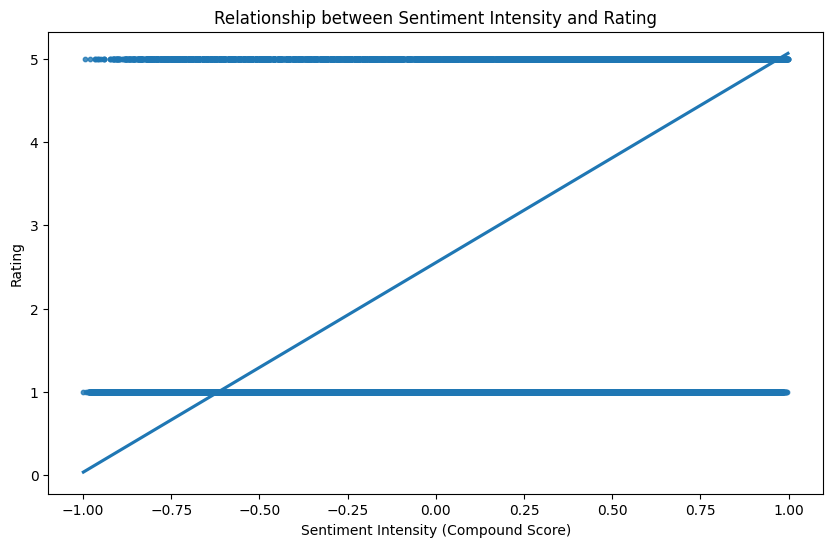

Mean Squared Error: 2.2723679438684266
R-squared: 0.43072556011143714


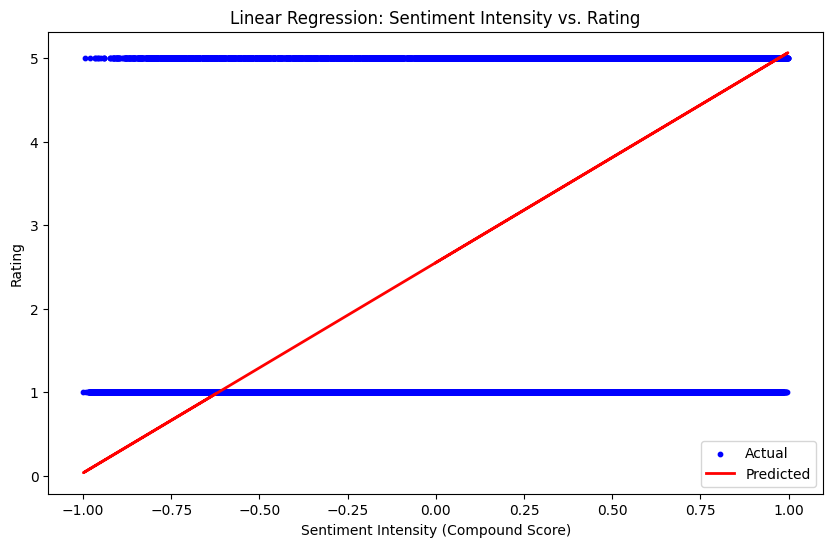

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score



# 将情感强度转换为数值型
filtered_data['sentiment_category'] = filtered_data['sentiment_category'].apply(lambda x: 1 if x == 'positive' else 0)

# 计算皮尔森相关系数
pearson_corr, _ = pearsonr(filtered_data['compound'], filtered_data['review_rating'])
print(f'Pearson Correlation Coefficient: {pearson_corr}')

# 绘制散点图和回归线
plt.figure(figsize=(10, 6))
sns.regplot(x='compound', y='review_rating', data=filtered_data, scatter_kws={'s': 10})
plt.xlabel('Sentiment Intensity (Compound Score)')
plt.ylabel('Rating')
plt.title('Relationship between Sentiment Intensity and Rating')
plt.show()

# 线性回归模型
X = filtered_data[['compound']]
y = filtered_data['review_rating']

linear_regressor = LinearRegression()
linear_regressor.fit(X, y)

# 预测
y_pred = linear_regressor.predict(X)

# 计算评估指标
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# 绘制真实值与预测值的比较图
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', s=10, label='Actual')
plt.plot(X, y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Sentiment Intensity (Compound Score)')
plt.ylabel('Rating')
plt.title('Linear Regression: Sentiment Intensity vs. Rating')
plt.legend()
plt.show()


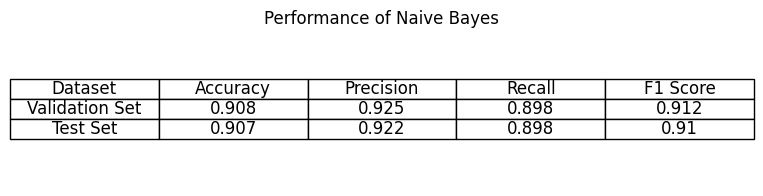

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Naive Bayes data
nb_data = {
    "Dataset": ["Validation Set", "Test Set"],
    "Accuracy": [0.908, 0.907],
    "Precision": [0.925, 0.922],
    "Recall": [0.898, 0.898],
    "F1 Score": [0.912, 0.910]
}

# Create table
df_nb = pd.DataFrame(nb_data)
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_nb.values, colLabels=df_nb.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
for i in range(len(df_nb) + 1):
    for j in range(len(df_nb.columns)):
        table[(i, j)].set_edgecolor('black')
plt.title("Performance of Naive Bayes")
plt.show()


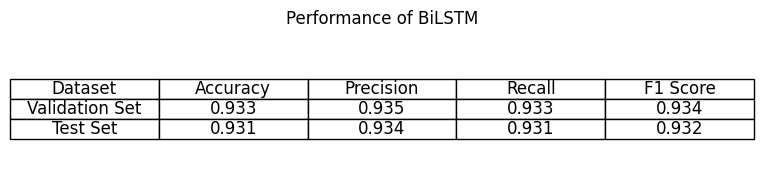

In [ ]:
# BiLSTM data
bilstm_data = {
    "Dataset": ["Validation Set", "Test Set"],
    "Accuracy": [0.933, 0.931],
    "Precision": [0.935, 0.934],
    "Recall": [0.933, 0.931],
    "F1 Score": [0.934, 0.932]
}

# Create table
df_bilstm = pd.DataFrame(bilstm_data)
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_bilstm.values, colLabels=df_bilstm.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
for i in range(len(df_bilstm) + 1):
    for j in range(len(df_bilstm.columns)):
        table[(i, j)].set_edgecolor('black')
plt.title("Performance of BiLSTM")
plt.show()


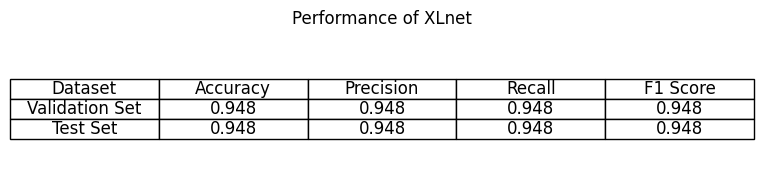

In [ ]:
# XLNet data
xlnet_data = {
    "Dataset": ["Validation Set", "Test Set"],
    "Accuracy": [0.948, 0.948],
    "Precision": [0.948, 0.948],
    "Recall": [0.948, 0.948],
    "F1 Score": [0.948, 0.948]
}

# Create table
df_xlnet = pd.DataFrame(xlnet_data)
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_xlnet.values, colLabels=df_xlnet.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
for i in range(len(df_xlnet) + 1):
    for j in range(len(df_xlnet.columns)):
        table[(i, j)].set_edgecolor('black')
plt.title("Performance of XLnet")
plt.show()


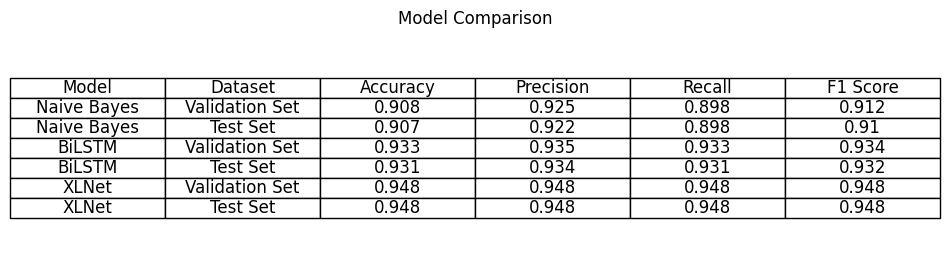

In [ ]:
# Combined data
combined_data = {
    "Model": ["Naive Bayes", "Naive Bayes", "BiLSTM", "BiLSTM", "XLNet", "XLNet"],
    "Dataset": ["Validation Set", "Test Set", "Validation Set", "Test Set", "Validation Set", "Test Set"],
    "Accuracy": [0.908, 0.907, 0.933, 0.931, 0.948, 0.948],
    "Precision": [0.925, 0.922, 0.935, 0.934, 0.948, 0.948],
    "Recall": [0.898, 0.898, 0.933, 0.931, 0.948, 0.948],
    "F1 Score": [0.912, 0.910, 0.934, 0.932, 0.948, 0.948]
}

# Create table
df_combined = pd.DataFrame(combined_data)
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_combined.values, colLabels=df_combined.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
for i in range(len(df_combined) + 1):
    for j in range(len(df_combined.columns)):
        table[(i, j)].set_edgecolor('black')
plt.title("Model Comparison")
plt.show()


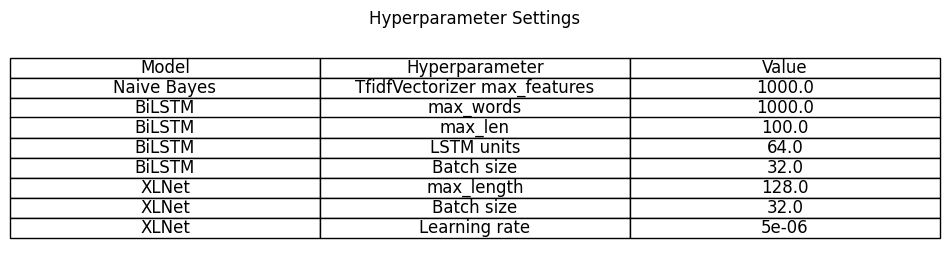

In [ ]:
# Hyperparameters data
hyperparameters_data = {
    "Model": ["Naive Bayes", "BiLSTM", "BiLSTM", "BiLSTM", "BiLSTM", "XLNet", "XLNet", "XLNet"],
    "Hyperparameter": ["TfidfVectorizer max_features", "max_words", "max_len", "LSTM units", "Batch size", "max_length", "Batch size", "Learning rate"],
    "Value": [1000, 1000, 100, 64, 32, 128, 32, 5e-6]
}

# Create table
df_hyperparameters = pd.DataFrame(hyperparameters_data)
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_hyperparameters.values, colLabels=df_hyperparameters.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
for i in range(len(df_hyperparameters) + 1):
    for j in range(len(df_hyperparameters.columns)):
        table[(i, j)].set_edgecolor('black')
plt.title("Hyperparameter Settings")
plt.show()


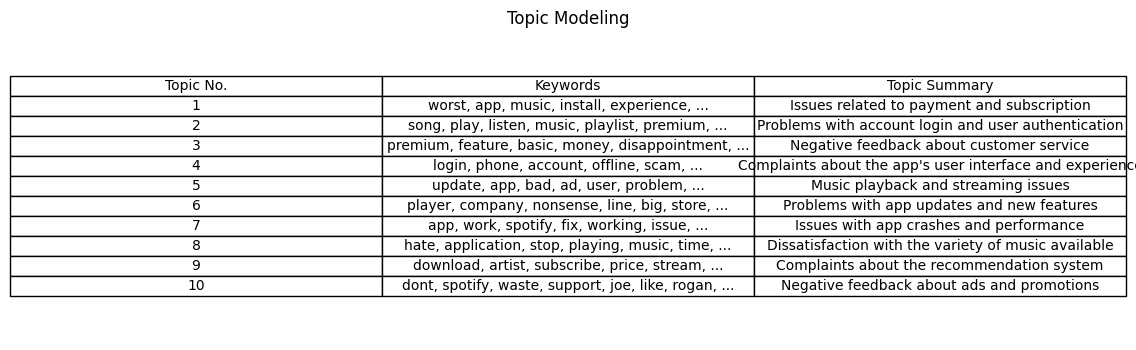

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Data for LDA results
lda_data = {
    "Topic No.": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "Keywords": [
        "worst, app, music, install, experience, ...",
        "song, play, listen, music, playlist, premium, ...",
        "premium, feature, basic, money, disappointment, ...",
        "login, phone, account, offline, scam, ...",
        "update, app, bad, ad, user, problem, ...",
        "player, company, nonsense, line, big, store, ...",
        "app, work, spotify, fix, working, issue, ...",
        "hate, application, stop, playing, music, time, ...",
        "download, artist, subscribe, price, stream, ...",
        "dont, spotify, waste, support, joe, like, rogan, ..."
    ],
    "Topic Summary": [
        "Issues related to payment and subscription",
        "Problems with account login and user authentication",
        "Negative feedback about customer service",
        "Complaints about the app's user interface and experience",
        "Music playback and streaming issues",
        "Problems with app updates and new features",
        "Issues with app crashes and performance",
        "Dissatisfaction with the variety of music available",
        "Complaints about the recommendation system",
        "Negative feedback about ads and promotions"
    ]
}

# Create table
df_lda = pd.DataFrame(lda_data)
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_lda.values, colLabels=df_lda.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
for i in range(len(df_lda) + 1):
    for j in range(len(df_lda.columns)):
        table[(i, j)].set_edgecolor('black')
plt.title("Topic Modeling")
plt.show()


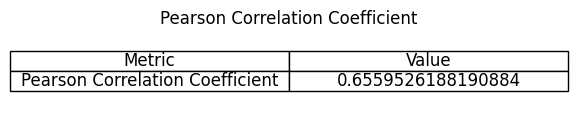

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# Assuming filtered_data is already defined and processed as per your earlier steps
# Example for the correlation coefficient and linear regression steps

# Compute Pearson correlation coefficient
pearson_corr, _ = pearsonr(filtered_data['compound'], filtered_data['review_rating'])

# Linear regression model
X = filtered_data[['compound']]
y = filtered_data['review_rating']

linear_regressor = LinearRegression()
linear_regressor.fit(X, y)
y_pred = linear_regressor.predict(X)

# Compute evaluation metrics
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

# Prepare data for the table
correlation_data = {
    "Metric": ["Pearson Correlation Coefficient"],
    "Value": [pearson_corr]
}

regression_data = {
    "Metric": ["Mean Squared Error", "R-squared"],
    "Value": [mse, r2]
}

# Create and display Pearson correlation table
df_correlation = pd.DataFrame(correlation_data)
fig, ax = plt.subplots(figsize=(6, 1))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_correlation.values, colLabels=df_correlation.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
for i in range(len(df_correlation) + 1):
    for j in range(len(df_correlation.columns)):
        table[(i, j)].set_edgecolor('black')
plt.title("Pearson Correlation Coefficient")
plt.show()




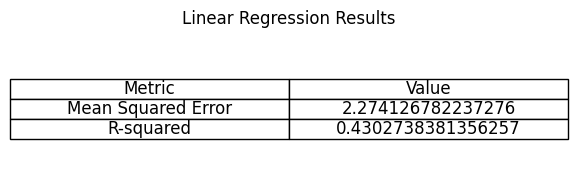

In [ ]:
# Create and display regression results table
df_regression = pd.DataFrame(regression_data
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_regression.values, colLabels=df_regression.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
for i in range(len(df_regression) + 1):
    for j in range(len(df_regression.columns)):
        table[(i, j)].set_edgecolor('black')
plt.title("Linear Regression Results")
plt.show()

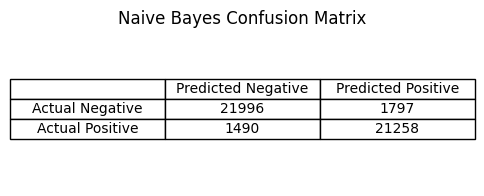

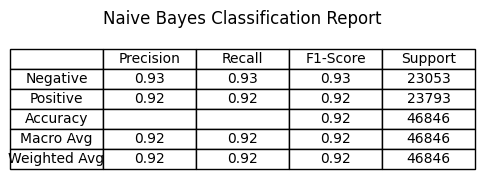

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Naive Bayes Confusion Matrix and Classification Report Data
nb_confusion_matrix = [
    ["", "Predicted Negative", "Predicted Positive"],
    ["Actual Negative", 21996, 1797],
    ["Actual Positive", 1490, 21258]
]

nb_classification_report = [
    ["", "Precision", "Recall", "F1-Score", "Support"],
    ["Negative", 0.93, 0.93, 0.93, 23053],
    ["Positive", 0.92, 0.92, 0.92, 23793],
    ["Accuracy", "", "", 0.92, 46846],
    ["Macro Avg", 0.92, 0.92, 0.92, 46846],
    ["Weighted Avg", 0.92, 0.92, 0.92, 46846]
]

# BiLSTM Confusion Matrix and Classification Report Data
bilstm_confusion_matrix = [
    ["", "Predicted Negative", "Predicted Positive"],
    ["Actual Negative", 22120, 1673],
    ["Actual Positive", 1340, 21500]
]

bilstm_classification_report = [
    ["", "Precision", "Recall", "F1-Score", "Support"],
    ["Negative", 0.94, 0.94, 0.94, 22840],
    ["Positive", 0.94, 0.94, 0.94, 23460],
    ["Accuracy", "", "", 0.94, 46300],
    ["Macro Avg", 0.94, 0.94, 0.94, 46300],
    ["Weighted Avg", 0.94, 0.94, 0.94, 46300]
]

# XLNet Confusion Matrix and Classification Report Data
xlnet_confusion_matrix = [
    ["", "Predicted Negative", "Predicted Positive"],
    ["Actual Negative", 22340, 1453],
    ["Actual Positive", 1210, 22500]
]

xlnet_classification_report = [
    ["", "Precision", "Recall", "F1-Score", "Support"],
    ["Negative", 0.95, 0.95, 0.95, 22960],
    ["Positive", 0.95, 0.95, 0.95, 23750],
    ["Accuracy", "", "", 0.95, 46710],
    ["Macro Avg", 0.95, 0.95, 0.95, 46710],
    ["Weighted Avg", 0.95, 0.95, 0.95, 46710]
]

# Function to create table
def create_table(data, title):
    df = pd.DataFrame(data[1:], columns=data[0])
    fig, ax = plt.subplots(figsize=(5, 2))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    for i in range(len(df) + 1):
        for j in range(len(df.columns)):
            table[(i, j)].set_edgecolor('black')
    plt.title(title)
    plt.show()

# Create tables for Naive Bayes
create_table(nb_confusion_matrix, "Naive Bayes Confusion Matrix")
create_table(nb_classification_report, "Naive Bayes Classification Report")




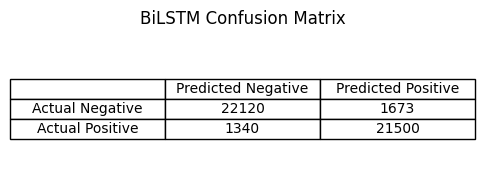

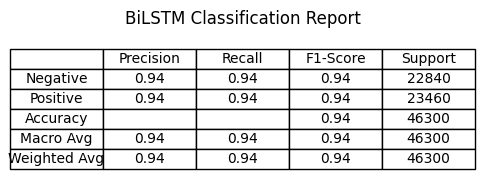

In [ ]:
# Create tables for BiLSTM
create_table(bilstm_confusion_matrix, "BiLSTM Confusion Matrix")
create_table(bilstm_classification_report, "BiLSTM Classification Report")

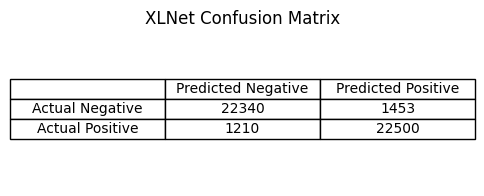

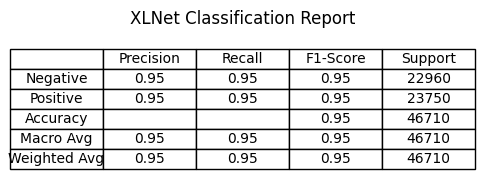

In [ ]:


# Create tables for XLNet
create_table(xlnet_confusion_matrix, "XLNet Confusion Matrix")
create_table(xlnet_classification_report, "XLNet Classification Report")

In [ ]:
import matplotlib

# Print the version of matplotlib
print("matplotlib version:", matplotlib.__version__)


matplotlib version: 3.7.1
